# Meta-Labelling Explained: Filter Noise, Boost Precision, Win More

In this notebook, we walk through the **full workflow of a meta-labelling strategy** using a realistic trading scenario.

We'll follow these steps:

1. **📈 Create a basic signal**: based on a classic moving average crossover.
2. **🏁 Apply the Triple Barrier Method**: to label each signal as a win, loss, or neutral.
3. **🧠 Engineer features**: capturing market structure (volatility, distribution, memory).
4. **⚙️ Train a meta-model**: using a Support Vector Classifier to decide which signals are worth acting on.
5. **📊 Evaluate performance**: comparing raw signals vs. filtered signals (meta-model).

> The goal is not to deliver a production-ready model, but to **understand the logic** behind meta-labelling, and how it can **filter noisy trading signals** to improve your edge.

<br>

👉 Full Newsletter about this subject available here: [Click here](https://open.substack.com/pub/quantreo/p/meta-labelling-explained-filter-noise?r=1o765i&utm_campaign=post&utm_medium=web&showWelcomeOnShare=true)

📚 Full course talking about ML for Trading: [Click here](https://www.quantreo.com/ml4trading-course/)

In [120]:
# Import the Features & Target Engineering Package from Quantreo
import quantreo.features_engineering as fe
import quantreo.target_engineering as te

# Import scikit-learn packages
from sklearn.preprocessing import StandardScaler

# Import pandas & Numpy
import pandas as pd
import numpy as np

# To display the graphics
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

# To remove some warnings
import warnings
warnings.filterwarnings("ignore")

In [105]:
# Import a dataset to test the functions and create new ones easily
from quantreo.datasets import load_generated_ohlcv_with_time
df = load_generated_ohlcv_with_time()

# Show the data
df

,open,high,low,close,volume,low_time,high_time
time,,,,,,,
2015-05-11 20:00:00,100.000000,100.358754,99.971765,100.113771,868.291731,2015-05-11 20:23:00,2015-05-11 20:53:00
2015-05-12 00:00:00,100.113771,100.274415,100.068157,100.197068,538.344102,2015-05-12 03:50:00,2015-05-12 00:18:00
2015-05-12 04:00:00,100.197068,100.621953,100.171421,100.550996,623.520889,2015-05-12 04:21:00,2015-05-12 07:47:00
2015-05-12 08:00:00,100.553515,100.789037,100.544627,100.759708,752.315201,2015-05-12 09:02:00,2015-05-12 11:49:00
2015-05-12 12:00:00,100.756989,100.975667,100.701889,100.769042,1260.121555,2015-05-12 15:37:00,2015-05-12 12:44:00
...,...,...,...,...,...,...,...
2024-11-13 04:00:00,102.104104,102.160879,101.878808,101.931978,431.101813,2024-11-13 07:23:00,2024-11-13 04:02:00
2024-11-13 08:00:00,101.931978,102.091758,101.931110,102.015341,1091.853172,2024-11-13 10:14:00,2024-11-13 12:00:00
2024-11-13 12:00:00,102.016217,102.082893,101.672509,101.853754,1848.353946,2024-11-13 13:28:00,2024-11-13 15:31:00


## Basic Trading Signal Using SMA Crossover

We create a simple buy signal based on the crossing of two moving averages:
a fast one (20 periods) and a slower one (60 periods).
A signal is triggered (signal = 1) when the fast SMA crosses above the slow SMA, a classic trend-following setup.

In [106]:
# Create two SMAs
df["fast_SMA"] = fe.trend.sma(df, col='close', window_size=20)
df["slow_SMA"] = fe.trend.sma(df, col='close', window_size=60)

# Create a buy signal when we have a crossing up
df["signal"] = 0
df.loc[(df["fast_SMA"].shift(1) < df["slow_SMA"].shift(1)) & (df["slow_SMA"] < df["fast_SMA"]), "signal"] = 1

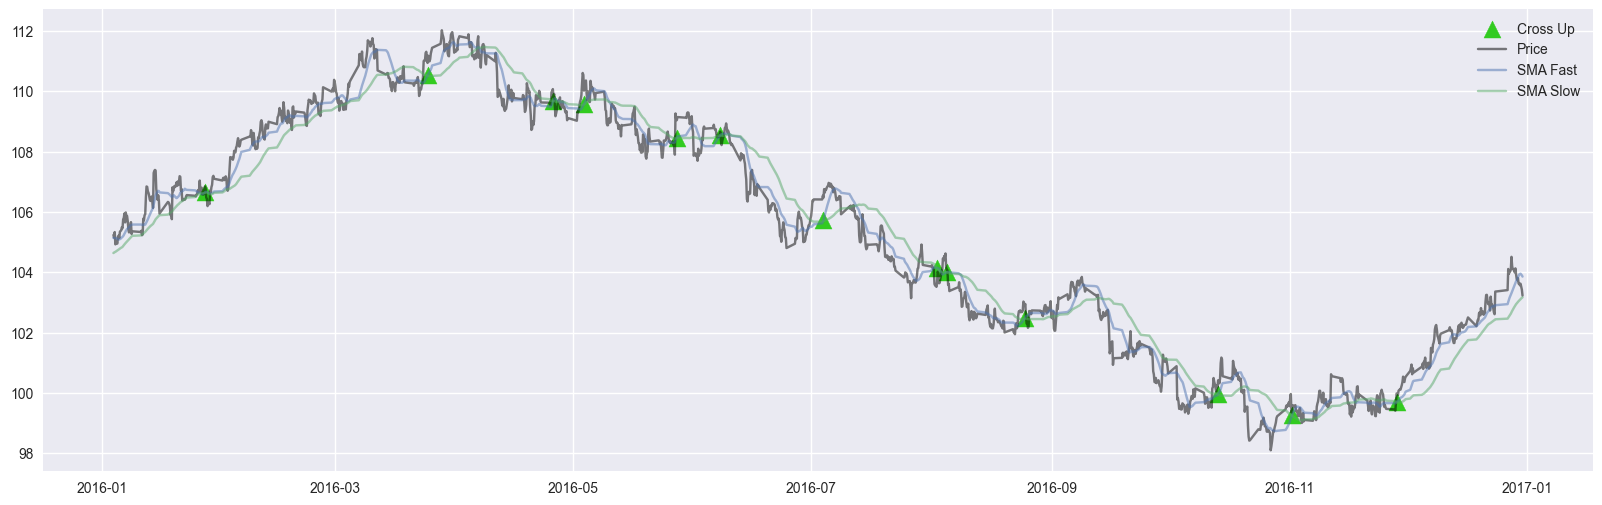

In [128]:
# Sample the dataset to show it better
dft=df.loc["2016"]

# Create a large figure for better visibility
plt.figure(figsize=(20, 6))

# Plot upward cross signals as green triangles
plt.scatter(dft.loc[dft["signal"]==1].index, dft.loc[dft.loc[dft["signal"]==1].index, "fast_SMA"],
            marker='^', color='#32CB20', s=150, label='Cross Up')

# Plot the price line in yellow with transparency
plt.plot(dft["close"], color="black", label="Price", alpha=0.50)
plt.plot(dft["fast_SMA"], label="SMA Fast", alpha=0.50)
plt.plot(dft["slow_SMA"], label="SMA Slow", alpha=0.50)

# Show the graph
plt.legend()
plt.show()

<br>

## Triple Barrier Labelling for Signal Evaluation
We apply the Triple Barrier Method to label each trade signal using realistic trade dynamics.
With a take-profit of 0.5% and a stop-loss of -0.5%, the method evaluates whether each signal would have resulted in a win (+1), a loss (-1), or timed out (0), based on the price action after the entry point.

In [45]:
# Create a Triple Barrier Labeling
df["label"] = te.directional.triple_barrier_labeling(df, 150, open_col="open", high_col="high", low_col="low", high_time_col="high_time",
    low_time_col="low_time", tp=0.005, sl=-0.005, buy=True)

100%|█████████████████████████████████| 14792/14792 [00:00<00:00, 829617.90it/s]


In [46]:
df

,open,high,low,close,volume,low_time,high_time,fast_SMA,slow_SMA,signal,label
time,,,,,,,,,,,
2015-05-11 20:00:00,100.000000,100.358754,99.971765,100.113771,868.291731,2015-05-11 20:23:00,2015-05-11 20:53:00,NaN,NaN,0,1
2015-05-12 00:00:00,100.113771,100.274415,100.068157,100.197068,538.344102,2015-05-12 03:50:00,2015-05-12 00:18:00,NaN,NaN,0,1
2015-05-12 04:00:00,100.197068,100.621953,100.171421,100.550996,623.520889,2015-05-12 04:21:00,2015-05-12 07:47:00,NaN,NaN,0,1
2015-05-12 08:00:00,100.553515,100.789037,100.544627,100.759708,752.315201,2015-05-12 09:02:00,2015-05-12 11:49:00,NaN,NaN,0,1
2015-05-12 12:00:00,100.756989,100.975667,100.701889,100.769042,1260.121555,2015-05-12 15:37:00,2015-05-12 12:44:00,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-13 04:00:00,102.104104,102.160879,101.878808,101.931978,431.101813,2024-11-13 07:23:00,2024-11-13 04:02:00,102.347967,102.850859,0,0
2024-11-13 08:00:00,101.931978,102.091758,101.931110,102.015341,1091.853172,2024-11-13 10:14:00,2024-11-13 12:00:00,102.304248,102.813318,0,0
2024-11-13 12:00:00,102.016217,102.082893,101.672509,101.853754,1848.353946,2024-11-13 13:28:00,2024-11-13 15:31:00,102.251171,102.776545,0,0


<br>

## Feature Engineering for Meta-Labelling

To train our meta-model, we generate a rich set of volatility and distribution-based features.
These include multiple volatility estimators (Close-to-Close, Parkinson, Rogers-Satchell, Yang-Zhang), price distribution bands, autocorrelation, and the Hurst exponent — all designed to capture the structure and behavior of price movement around our signals.
We also compute a volatility average to reduce dimensionality and keep only features related to active buy signals.

In [48]:
# Standard volatility features
df["vol_close_to_close_30"] = fe.volatility.close_to_close_volatility(df, window_size=30)
df["vol_close_to_close_60"] = fe.volatility.close_to_close_volatility(df, window_size=60)
df["vol_close_to_close_90"] = fe.volatility.close_to_close_volatility(df, window_size=90)


# Parkinson volatility features
df["vol_parkinson_30"] = fe.volatility.parkinson_volatility(df, high_col="high", low_col="low", window_size=30)
df["vol_parkinson_60"] = fe.volatility.parkinson_volatility(df, high_col="high", low_col="low", window_size=60)
df["vol_parkinson_90"] = fe.volatility.parkinson_volatility(df, high_col="high", low_col="low", window_size=90)


# Rogers Satchell volatility feature
df["vol_rogers_satchell_30"] = fe.volatility.rogers_satchell_volatility(df, high_col="high", low_col="low", open_col="open", close_col="close", window_size=30)
df["vol_rogers_satchell_60"] = fe.volatility.rogers_satchell_volatility(df, high_col="high", low_col="low", open_col="open", close_col="close", window_size=60)
df["vol_rogers_satchell_90"] = fe.volatility.rogers_satchell_volatility(df, high_col="high", low_col="low", open_col="open", close_col="close", window_size=90)

# Yang Zhang volatility feature
df["vol_yang_zhang_30"] = fe.volatility.yang_zhang_volatility(df, high_col="high", low_col="low", open_col="open", close_col="close", window_size=30)
df["vol_yang_zhang_60"] = fe.volatility.yang_zhang_volatility(df, high_col="high", low_col="low", open_col="open", close_col="close", window_size=60)
df["vol_yang_zhang_90"] = fe.volatility.yang_zhang_volatility(df, high_col="high", low_col="low", open_col="open", close_col="close", window_size=90)


# Price distribution
df['0_to_25'] = fe.candle.price_distribution(df, col="close", window_size=60, start_percentage=0.00, end_percentage=0.25)
df['25_to_75'] = fe.candle.price_distribution(df, col="close", window_size=60, start_percentage=0.25, end_percentage=0.75)
df['75_to_100'] = fe.candle.price_distribution(df, col="close", window_size=60, start_percentage=0.75, end_percentage=1.00)

# AutoCorr
df["auto_corr_10"] = fe.math.auto_corr(df=df, col="close", window_size=50, lag=10)

# Hurst
df["hurst_100"] = fe.math.hurst(df=df, col="close", window_size=100)

# Volatility Mean to reduce the number of features
vol_features = [col for col in df.columns if "vol_" in col and "volatility" not in col]
df["volatility_mean"] = df[vol_features].mean(axis=1)

In [55]:
# Conditionate the analysis to the Buy Signal
df = df[["volatility_mean", "auto_corr_10", "0_to_25", "25_to_75", "75_to_100", "hurst_100", "signal", "label"]].loc[df["signal"]==1].dropna()

In [56]:
# Define the train size
train_size = int(len(df) * 0.75)

# Chronological split
X_list = ["volatility_mean", "auto_corr_10", "0_to_25", "25_to_75", "75_to_100", "hurst_100"]
y_list = ["label"]

# Split the dataset
X_train = df.iloc[:train_size][X_list]
y_train = df.iloc[:train_size][y_list]
X_test = df.iloc[train_size:][X_list]
y_test = df.iloc[train_size:][y_list]

In [57]:
df

,volatility_mean,auto_corr_10,0_to_25,25_to_75,75_to_100,hurst_100,signal,label
time,,,,,,,,
2015-07-10 16:00:00,0.002159,-0.448941,25.000000,55.000000,20.000000,0.564863,1,1
2015-07-29 12:00:00,0.001951,-0.414811,31.666667,56.666667,11.666667,0.407086,1,-1
2015-08-18 16:00:00,0.002708,-0.141767,15.000000,51.666667,33.333333,0.398367,1,-1
2015-09-04 08:00:00,0.002063,0.064196,35.000000,50.000000,15.000000,0.456214,1,-1
2015-09-21 08:00:00,0.001888,0.017000,20.000000,51.666667,28.333333,0.494735,1,-1
...,...,...,...,...,...,...,...,...
2024-06-11 20:00:00,0.002043,-0.065222,13.333333,56.666667,30.000000,0.539516,1,1
2024-07-05 20:00:00,0.002231,-0.226993,11.666667,50.000000,38.333333,0.464584,1,-1
2024-07-26 08:00:00,0.002135,-0.088219,45.000000,50.000000,5.000000,0.553411,1,-1


<br>

## Standardization and Model Training
We standardize the feature set using StandardScaler to ensure that all inputs to the SVM have the same scale — a crucial step for distance-based models.
Then we train a basic Support Vector Classifier (SVC) on the labeled buy signals to learn how to distinguish between profitable, unprofitable, or neutral trades.

In [58]:
# Standardize the data to help the SVC
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [63]:
# Create and Train the model
from sklearn.svm import SVC
model = SVC()
model.fit(X_train_sc, y_train)

SVC()

## Prediction & Performance Analysis

Once our meta-model is trained, we evaluate its effectiveness compared to the raw trading signal.

We compute two key metrics:

- **Accuracy**: how often the model predicted the correct label.
- **Precision (positive trades)**: how often predicted positive trades (label = 1) were actually correct — this is especially important when you want to avoid false positives.

We also define a **baseline** where every trading signal is executed (i.e. always predict 1), to simulate the performance of the raw signal **without meta-labelling**.

Here is the comparison table:

|                | Accuracy | Precision (positive trades) |
|----------------|----------|------------------------------|
| Meta-model     | 0.556    | 0.478                        |
| Signal only    | 0.417    | 0.417                        |

👉 In this example, the meta-model improves both **accuracy** and **precision**, meaning it filters out some of the bad trades. But keep in mind: this is only a small test — not a final strategy.


In [123]:
from sklearn.metrics import accuracy_score, precision_score

# Meta-model predictions
y_pred_meta = model.predict(X_test_sc)

# Baseline: assume all signals are executed (always predict 1)
y_baseline = [1] * len(y_test)

# Compute metrics for meta-model
acc_meta = accuracy_score(y_test, y_pred_meta)
prec_meta = precision_score(y_test, y_pred_meta, labels=[1], average='macro')

# Compute metrics for raw signal
acc_signal = accuracy_score(y_test, y_baseline)
prec_signal = precision_score(y_test, y_baseline, labels=[1], average='macro')

# Compare results in a clear table
performance_df = pd.DataFrame({
    "Accuracy": [acc_meta, acc_signal],
    "Precision (positive trades)": [prec_meta, prec_signal]
}, index=["Meta-model", "Signal only"])

performance_df.round(3)


,Accuracy,Precision (positive trades)
Meta-model,0.556,0.478
Signal only,0.417,0.417


⚠️ **Important note before interpreting the results**  

In this example, our test set contains **only about 30 data points**, and the full dataset includes **fewer than 150 trades**.  
We’ve used a **simple train/test split**, with **no robustness testing**, no cross-validation, no sensitivity analysis, and no hyperparameter tuning.  

>
> These results are **not statistically significant**. They might look good here, but could easily fail in a different setting.  
>
The real goal of this notebook isn’t to show off a final model.  
It’s to help you understand how **meta-labelling works**, so you can build and refine **your own robust pipeline** later on.
